# DID

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import gpboost as gpb
from patsy import dmatrix

In [4]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

# 特定の列の外れ値を除去する例
column = 'population_change_rate'

# 平均と標準偏差の計算
mean = df[column].mean()
std = df[column].std()

# 外れ値の定義（ここでは3標準偏差を超えるデータを外れ値とみなす）
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# 外れ値を除去
df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 除去されたデータを確認
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
outliers

,island_names,years,island_ids,region_codes,region_names,prefecture_codes,populations,treatment_group,treatment_group_mainland,year_bridges_opened,...,cohort_2000,years_cohort_2000,cohort_2004,years_cohort_2004,cohort_2011,years_cohort_2011,cohort_2015,years_cohort_2015,cohort_2016,years_cohort_2016
5,鹿久居島,2000,68,33342,日生町,33,16,1,1,2015,...,0,0,0,0,0,0,1,-15,0,0
30,鴻島,1975,71,33342,日生町,33,76,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,松島,2000,78,33202,倉敷市,33,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131,生口島,1995,95,34430,（旧）瀬戸田町,34,11097,1,1,1991,...,0,0,0,0,0,0,0,0,0,0
149,長島,1985,103,34427,（旧）大崎町,34,39,1,0,1987,...,0,0,0,0,0,0,0,0,0,0
152,長島,2000,103,34427,（旧）大崎町,34,33,1,0,1987,...,0,0,0,0,0,0,0,0,0,0
227,沖野島,2000,118,34330,（旧）大柿町,34,7,1,1,1972,...,0,0,0,0,0,0,0,0,0,0
230,沖野島,2015,118,34215,江田島市,34,9,1,1,1972,...,0,0,0,0,0,0,0,0,0,0
243,笠佐島,2005,126,35305,周防大島町,35,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_cleaned['log_income'] = np.log(df_cleaned['income'])
df_cleaned['log_area'] = np.log(df_cleaned['area_km2'])
df_cleaned['log_distance'] = np.log(df_cleaned['distance_m'])
df_cleaned = df_cleaned.dropna(subset=['population_change_rate', 'log_income'])

## DID

In [65]:
y = df_cleaned['population_change_rate']
X = dmatrix('treatment_group * after_treatment', data=df_cleaned, return_type='dataframe')

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     population_change_rate   R-squared:                       0.045
Model:                                OLS   Adj. R-squared:                  0.042
Method:                     Least Squares   F-statistic:                     16.84
Date:                    Thu, 31 Oct 2024   Prob (F-statistic):           7.13e-08
Time:                            00:11:47   Log-Likelihood:                -2843.7
No. Observations:                     715   AIC:                             5693.
Df Residuals:                         712   BIC:                             5707.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [68]:
y = df_cleaned['population_change_rate']
group = df_cleaned['island_id']
X = dmatrix('treatment_group * after_treatment', data=df_cleaned, return_type='dataframe')

gp_model = gpb.GPModel(group_data=group, likelihood="gaussian")
gp_model.fit(y=y, X=X, params={'std_dev': True})
gp_model.summary()

[GPBoost] [Warning] The linear regression covariate data matrix (fixed effect) is rank deficient. This is not necessarily a problem when using gradient descent. If this is not desired, consider dropping some columns / covariates 
Model summary:
 Log-lik     AIC     BIC
 -2842.3 5696.59 5724.03
Nb. observations: 715
Nb. groups: 81 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
              Param.  Std. dev.
Error_term  160.6408     9.0026
island_id     6.2924     3.9491
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                  Param.  Std. dev.  z value  P(>|z|)
Intercept                       -15.5206        NaN      NaN      NaN
treatment_group                   6.2715        NaN      NaN      NaN
after_treatment                  -1.0956        inf     -0.0      1.0
treatment_group:after_treatment   0.0000        inf      0.0      1.0


## TWFE

In [70]:
y = df_cleaned['population_change_rate']
group = df_cleaned[['island_id']]
X = dmatrix('treatment_group + C(year) + C(passage_of_year) -1', data=df_cleaned, return_type='dataframe')

gp_model = gpb.GPModel(group_data=group, likelihood="gaussian")
gp_model.fit(y=y, X=X, params={'std_dev': True})
gp_model.summary()

Model summary:
 Log-lik     AIC     BIC
-2802.02 5726.05 6004.96
Nb. observations: 715
Nb. groups: 81 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
              Param.  Std. dev.
Error_term  142.2023     7.9712
island_id     7.4427     3.7939
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                           Param.  Std. dev.  z value  P(>|z|)
C(year)[1975]            -19.5590     1.6812 -11.6339   0.0000
C(year)[1980]            -13.4971     1.6650  -8.1063   0.0000
C(year)[1985]            -12.1701     1.6544  -7.3564   0.0000
C(year)[1990]            -13.0365     1.6566  -7.8695   0.0000
C(year)[1995]            -20.4333     1.6628 -12.2884   0.0000
C(year)[2000]            -15.1889     1.5092 -10.0639   0.0000
C(year)[2005]            -10.0058     1.5240  -6.5655   0.0000
C(year)[2010]            -15.6171     1.5437 -10.1167   0.0000
C(year)[2015]            -1

## Staggered DiD

$$
Y_{it} = \text{Treatment}_i + \text{Year}_t + \text{Passage} \times \text{Cohort}
$$

In [19]:
# 'cohort'から始まるカラムを抽出
years_cohort_columns = df_cleaned.filter(regex='^years_cohort').columns

# 新しいデータフレームにまとめる
df_years_cohort = df_cleaned[years_cohort_columns].drop(columns='years_cohort_0')

# 結果を表示
df_years_cohort.head()
df_years_cohort.describe()

,years_cohort_1972,years_cohort_1973,years_cohort_1975,years_cohort_1976,years_cohort_1979,years_cohort_1983,years_cohort_1987,years_cohort_1988,years_cohort_1989,years_cohort_1991,years_cohort_1992,years_cohort_1995,years_cohort_1996,years_cohort_1999,years_cohort_2000,years_cohort_2004,years_cohort_2011,years_cohort_2015,years_cohort_2016
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,0.323370,0.608696,0.475543,0.396739,1.394022,0.733696,0.298913,0.953804,0.290761,0.239130,0.252717,0.203804,0.375000,0.138587,0.190217,-0.032609,-0.057065,-0.230978,-0.138587
std,3.615935,4.589899,4.140509,3.834476,6.439377,4.548228,2.740910,4.616702,2.597362,2.375486,2.248522,1.924823,2.562701,1.534288,2.237094,1.705584,1.178603,2.366528,1.534288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,-6.000000,0.000000,0.000000,-1.000000,-4.000000,-15.000000,-19.000000,-16.000000,-30.000000,-21.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.000000,47.000000,45.000000,44.000000,41.000000,37.000000,33.000000,32.000000,31.000000,29.000000,28.000000,25.000000,24.000000,21.000000,20.000000,16.000000,9.000000,5.000000,4.000000


In [52]:
y = df_cleaned['population_change_rate']
years_cohort = 'C(years_cohort_1972) + C(years_cohort_1973) + C(years_cohort_1975) + C(years_cohort_1976) + C(years_cohort_1979) + C(years_cohort_1983) + C(years_cohort_1987) + C(years_cohort_1988) + C(years_cohort_1989) + C(years_cohort_1991) + C(years_cohort_1992) + C(years_cohort_1995) + C(years_cohort_1996) + C(years_cohort_1999) + C(years_cohort_2000) + C(years_cohort_2004) + C(years_cohort_2011) + C(years_cohort_2015) + C(years_cohort_2016)'
X = dmatrix(
    f'treatment_group + C(years) + C(island_ids) + {years_cohort} -1',
    data=df_cleaned,
    return_type='dataframe'
)

staggered_did_model = sm.OLS(y, X)
staggered_did_result = staggered_did_model.fit(cov_type='HC0')
print(staggered_did_result.summary())

                              OLS Regression Results                              
Dep. Variable:     population_change_rate   R-squared:                       0.492
Model:                                OLS   Adj. R-squared:                  0.086
Method:                     Least Squares   F-statistic:                       nan
Date:                    Fri, 01 Nov 2024   Prob (F-statistic):                nan
Time:                            13:21:23   Log-Likelihood:                -1339.6
No. Observations:                     368   AIC:                             3007.
Df Residuals:                         204   BIC:                             3648.
Df Model:                             163                                         
Covariance Type:                      HC0                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [ ]:
years = 2016
params_years_cohort = pd.DataFrame(columns=['cohort', 'passage_year' 'estimate', 'std_error'])
passage_years_list = [-16, -11, -1, 0, 4]


In [94]:
years_list = [1972, 1973, 1975, 1976, 1979, 1983, 1987, 1988, 1989, 1991, 1992, 1995, 1996, 1999, 2000, 2004, 2011, 2015, 2016]
passage_years = range(-50, 50)
params_years_cohort = pd.DataFrame(columns=['cohort', 'passage_year' 'estimate', 'std_error'])
params_years_cohort_list = []
for year in years_list:
    passage_years_list = [passage for passage in passage_years if f'C(years_cohort_{year})[T.{passage}]' in staggered_did_result.params.index]
    if passage_years_list:
        params_years_cohort = pd.DataFrame({
            'cohort': [year] * len(passage_years_list),
            'passage_year': passage_years_list,
            'estimate': staggered_did_result.params[[f'C(years_cohort_{year})[T.{passage}]' for passage in passage_years_list]],
            'std_error': staggered_did_result.bse[[f'C(years_cohort_{year})[T.{passage}]' for passage in passage_years_list]]
        })
        params_years_cohort_list.append(params_years_cohort)

# 結果を一つのデータフレームに結合
if params_years_cohort_list:
    params_years_cohort = pd.concat(params_years_cohort_list, ignore_index=True)
else:
    params_years_cohort = pd.DataFrame(columns=['cohort', 'passage_year', 'estimate', 'std_error'])

params_years_cohort

,cohort,passage_year,estimate,std_error
0,1972,33,-14.557079,2.087041
1,1972,38,6.672217,1.286200
2,1972,48,-1.359190,1.406618
3,1973,17,0.640466,3.911521
4,1973,22,7.597134,2.359991
...,...,...,...,...
106,2016,-11,-14.510807,3.644295
107,2016,-6,-11.342619,2.771333
108,2016,-1,-11.504350,3.120974
109,2016,0,-6.253068,2.828469


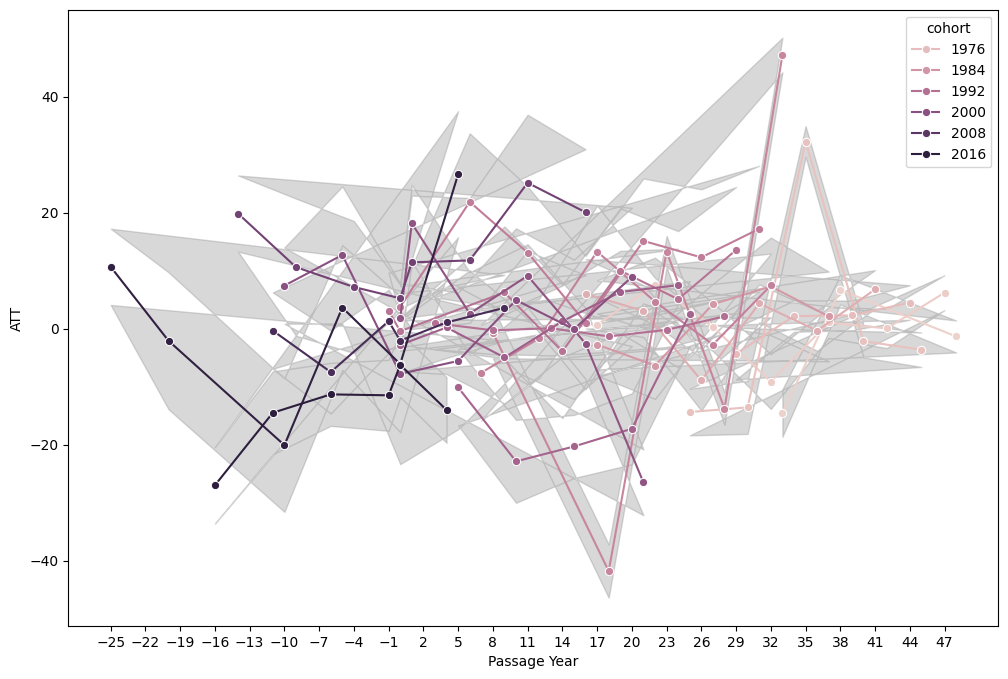

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=params_years_cohort, x='passage_year', y='estimate', hue='cohort' , marker='o')
plt.fill_between(
    params_years_cohort['passage_year'],
    params_years_cohort['estimate'] - 1.96 * params_years_cohort['std_error'],
    params_years_cohort['estimate'] + 1.96 * params_years_cohort['std_error'],
    color='gray',
    alpha=0.3
)

x_min = params_years_cohort['passage_year'].min()
x_max = params_years_cohort['passage_year'].max()
plt.xticks(np.arange(np.floor(x_min), np.ceil(x_max) + 1, 3))


plt.xlabel('Passage Year')
plt.ylabel('ATT')
plt.show()

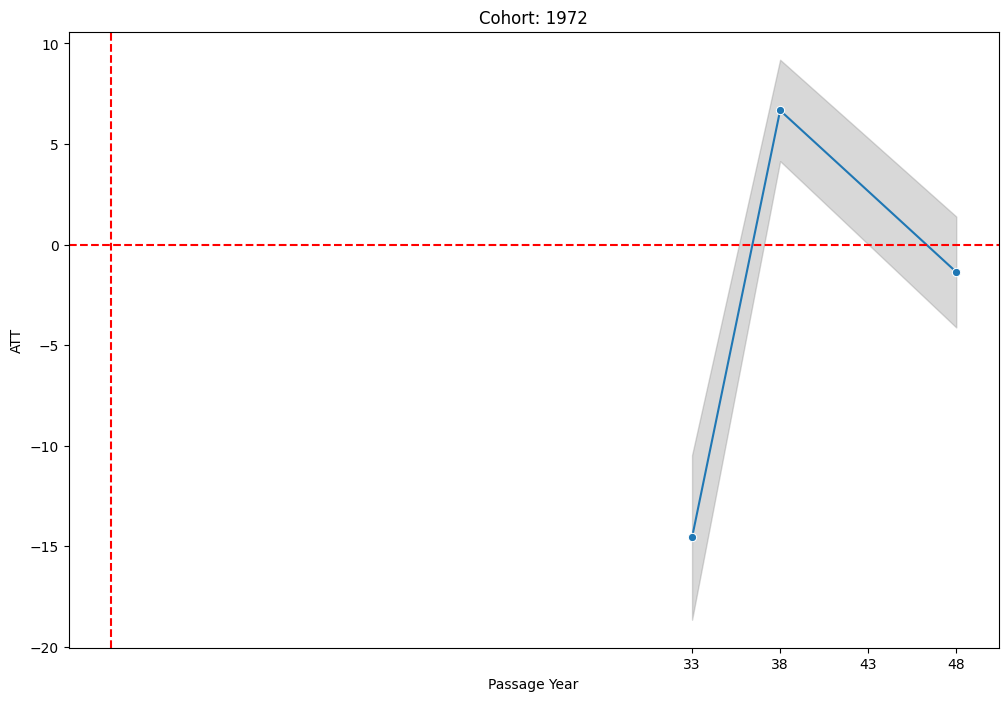

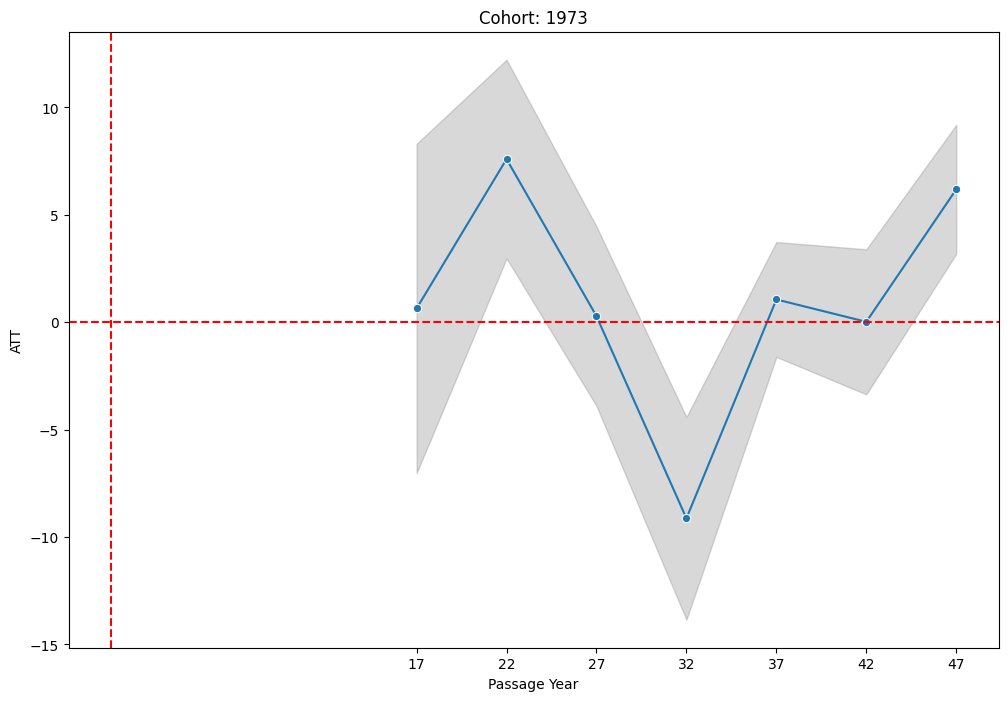

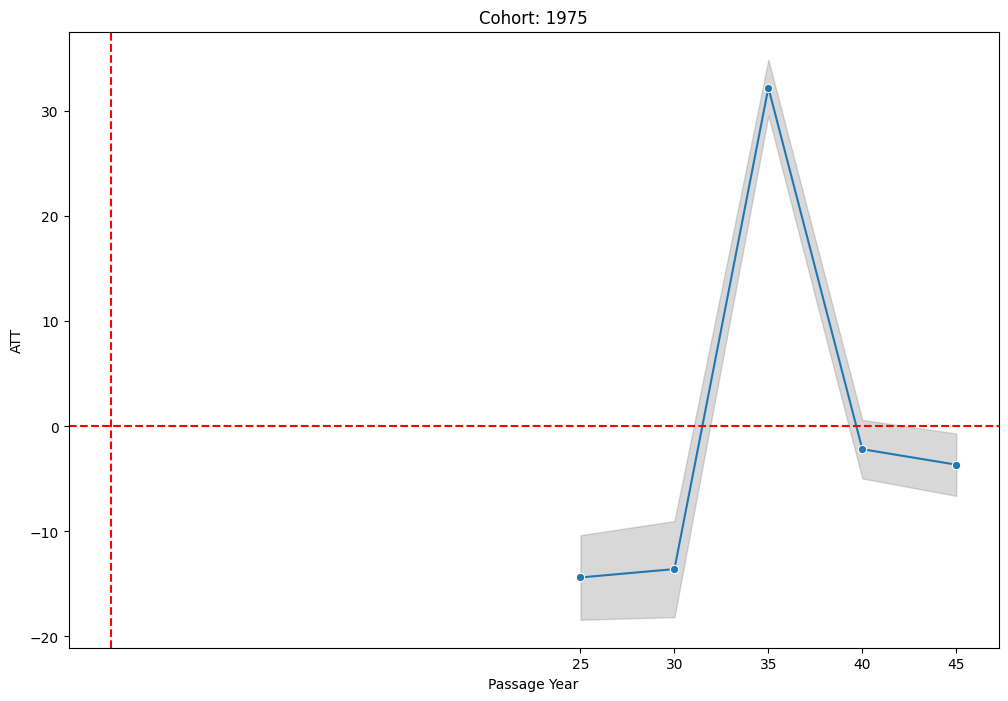

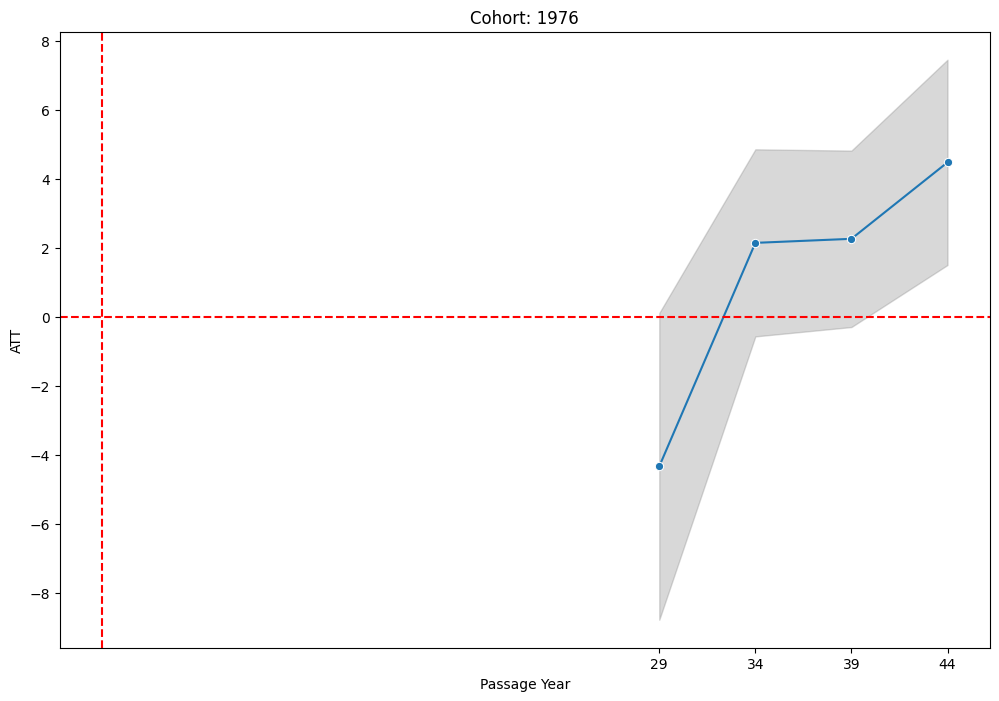

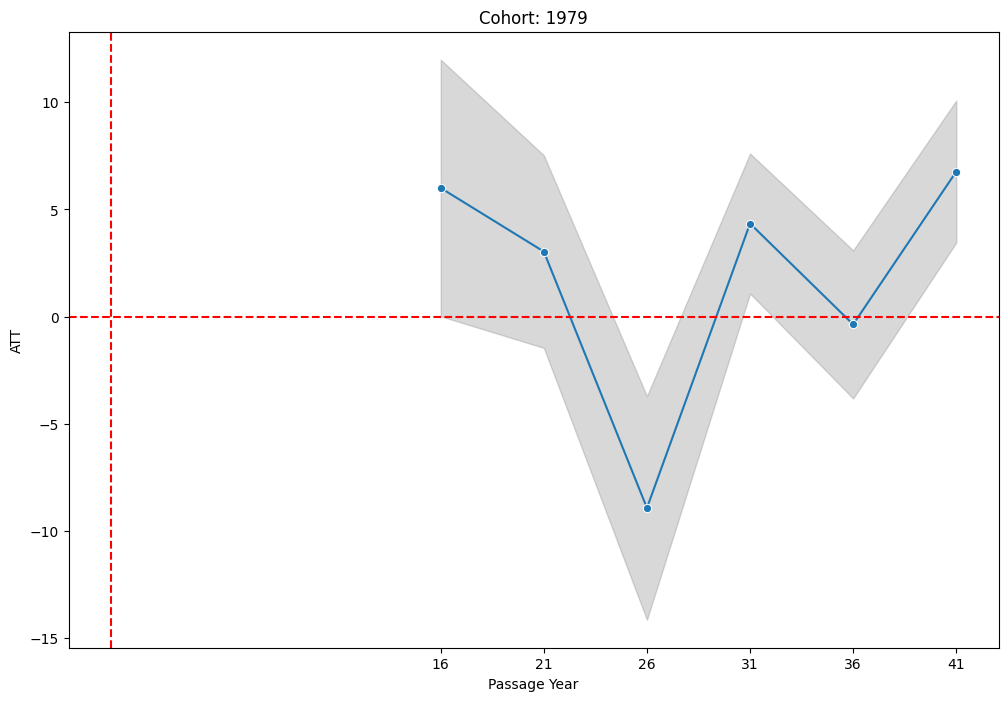

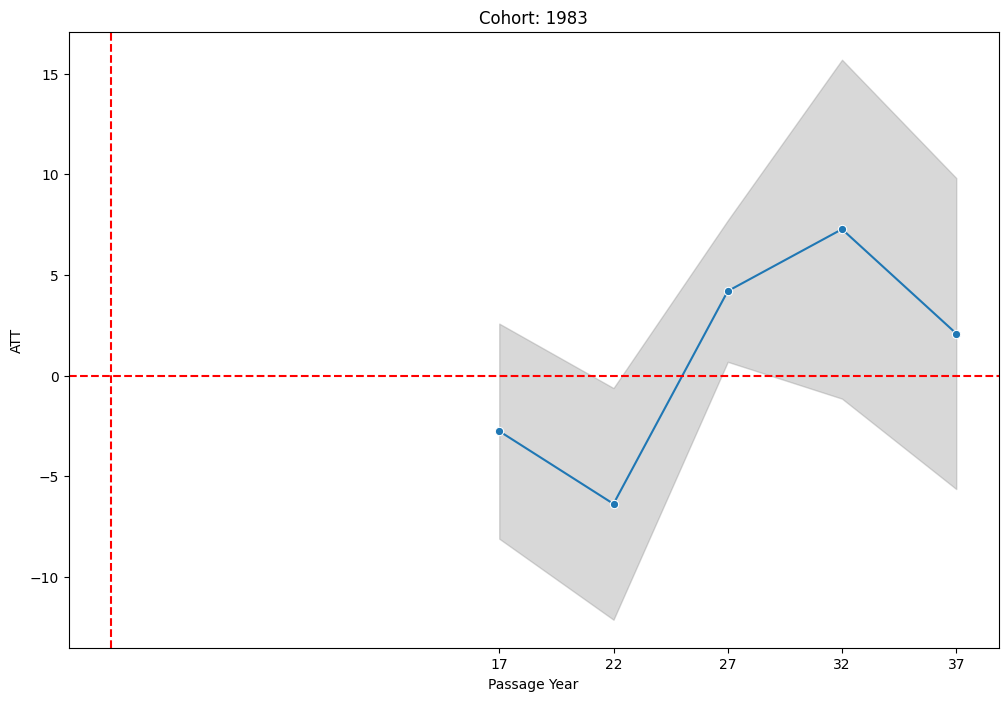

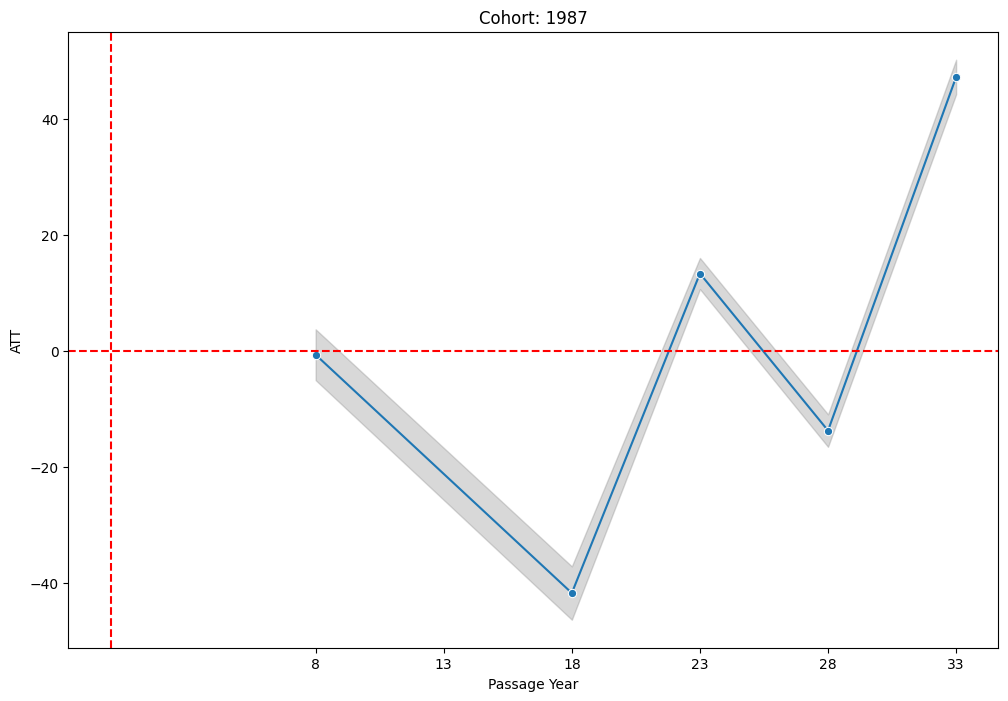

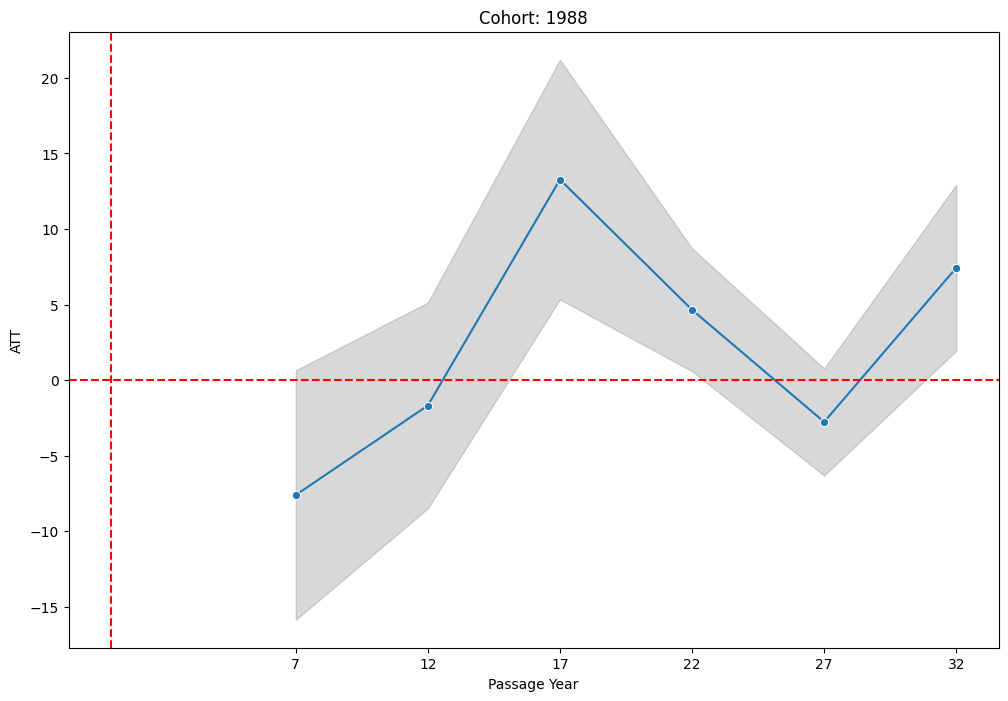

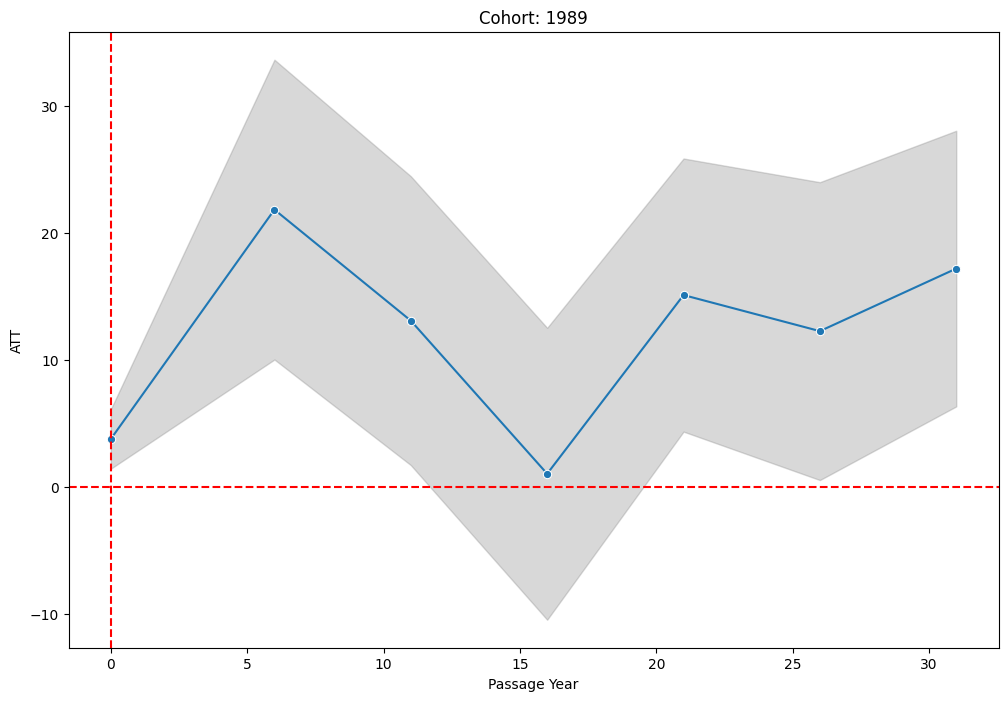

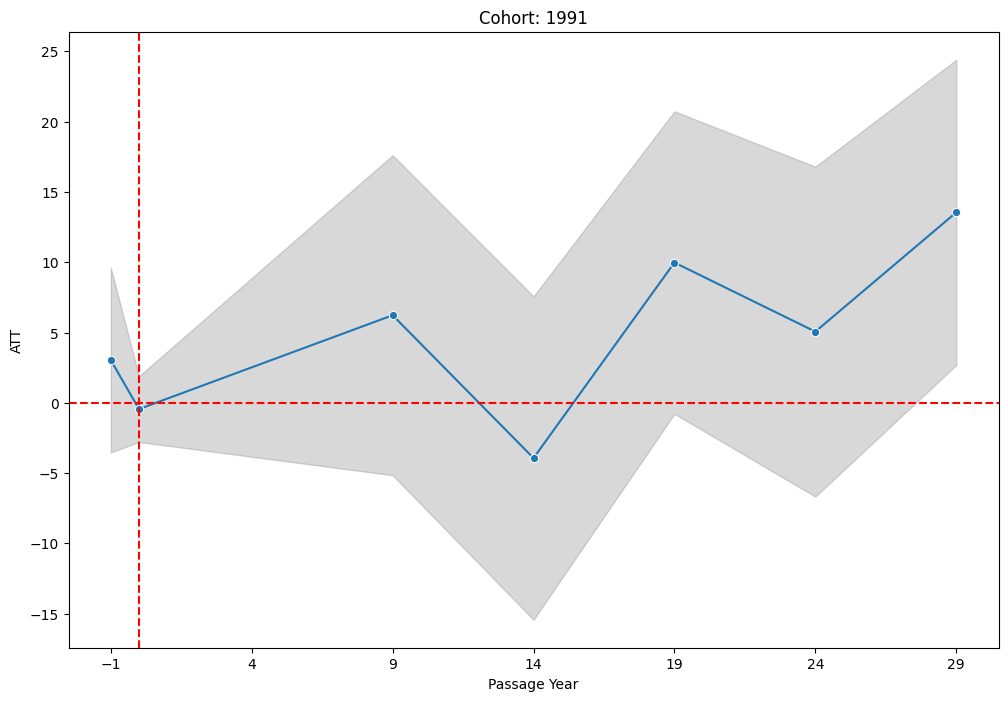

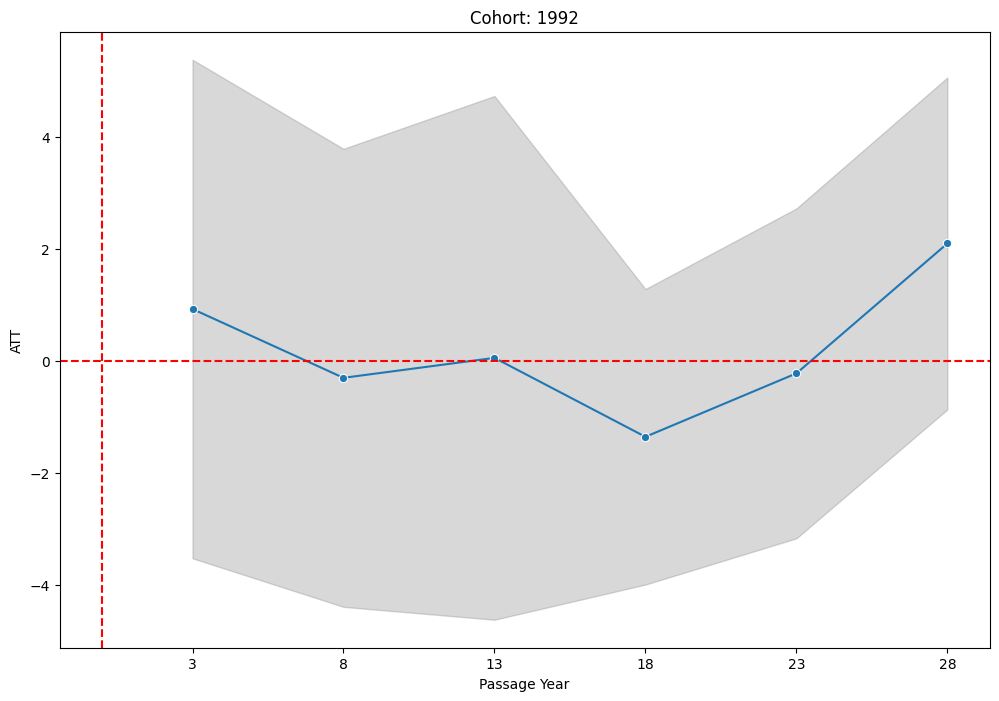

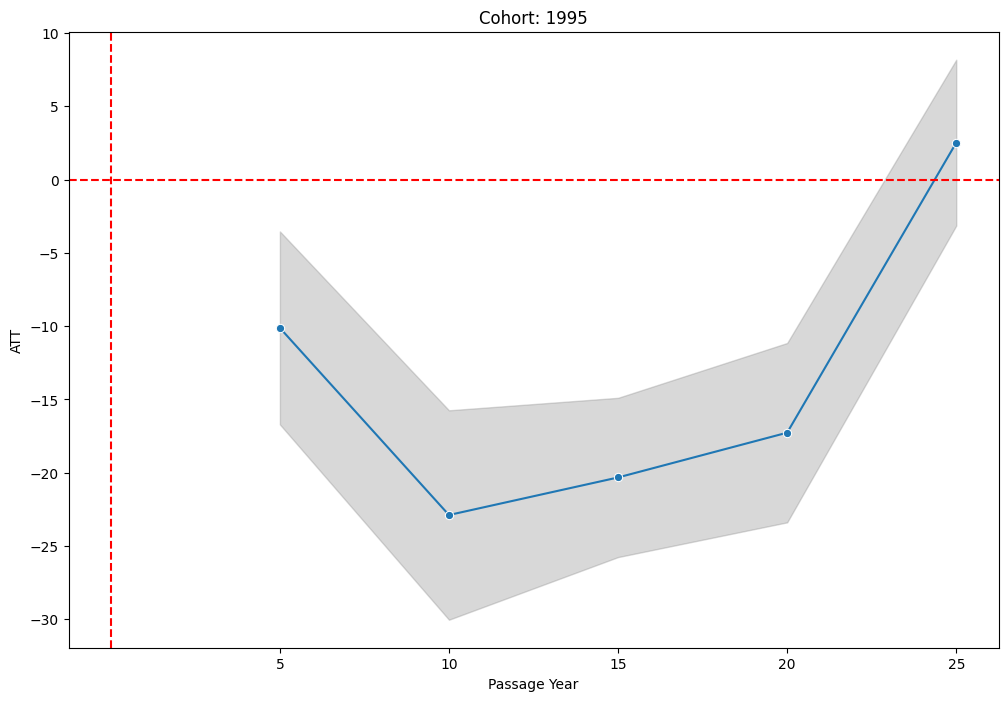

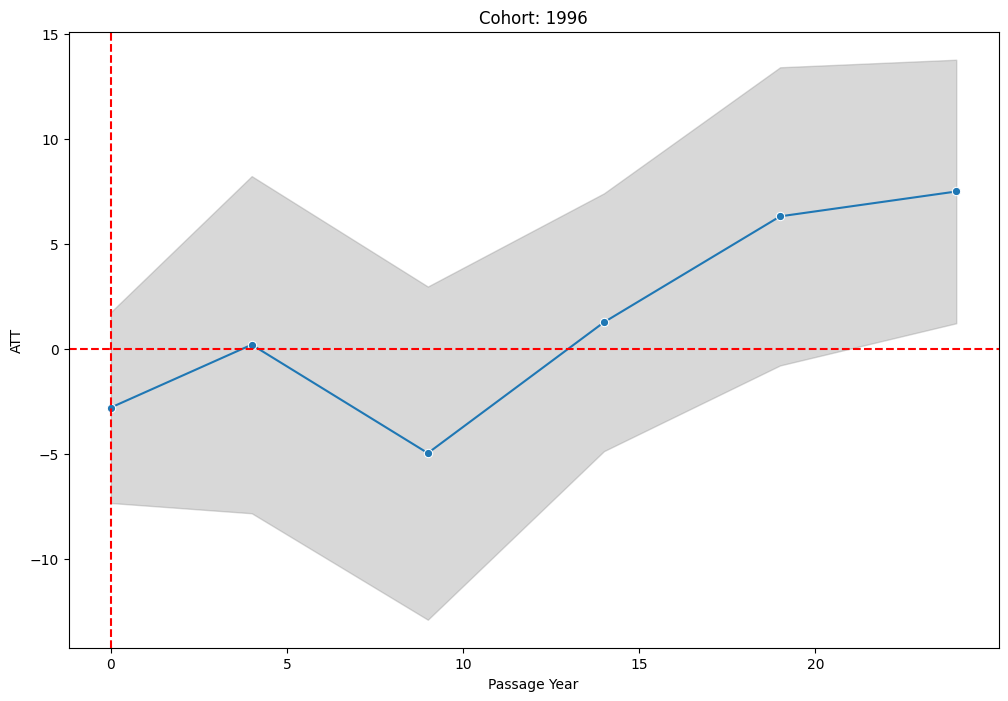

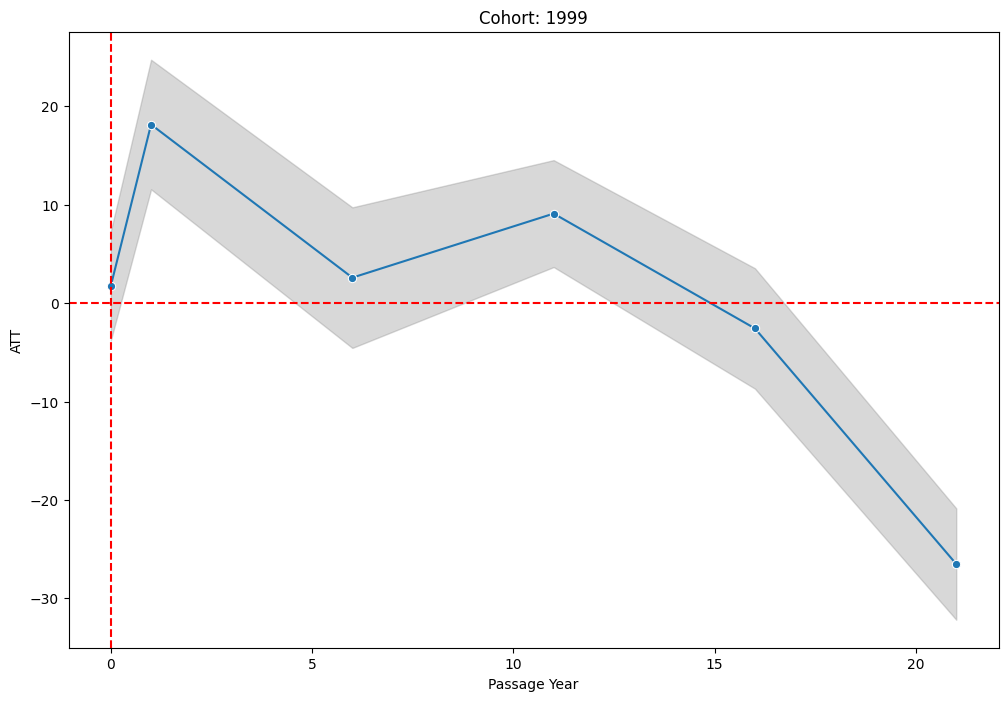

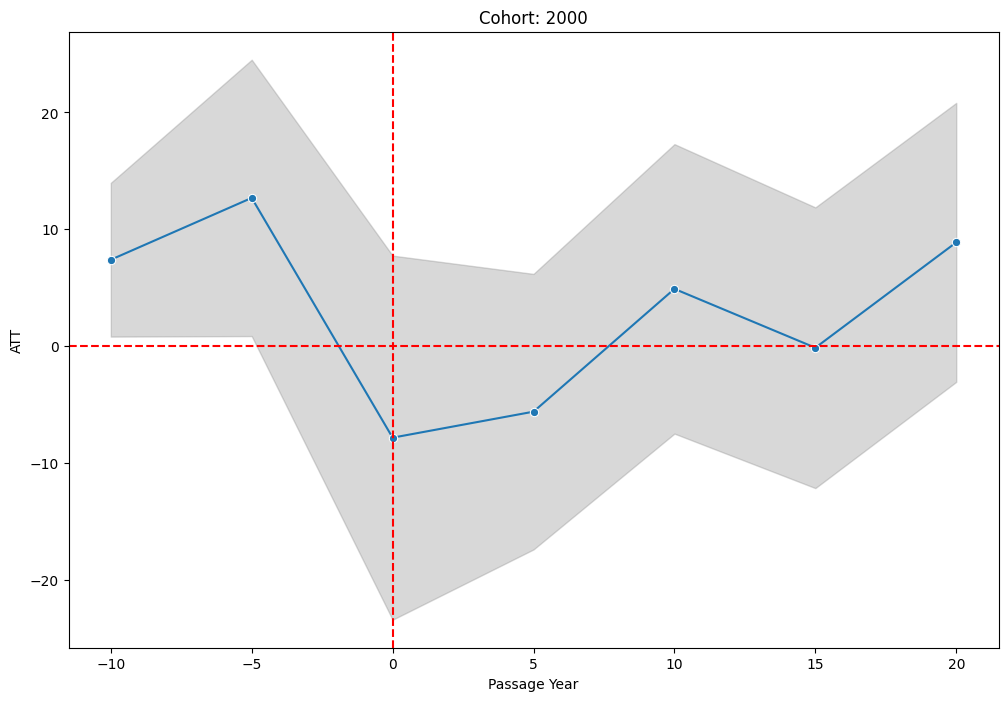

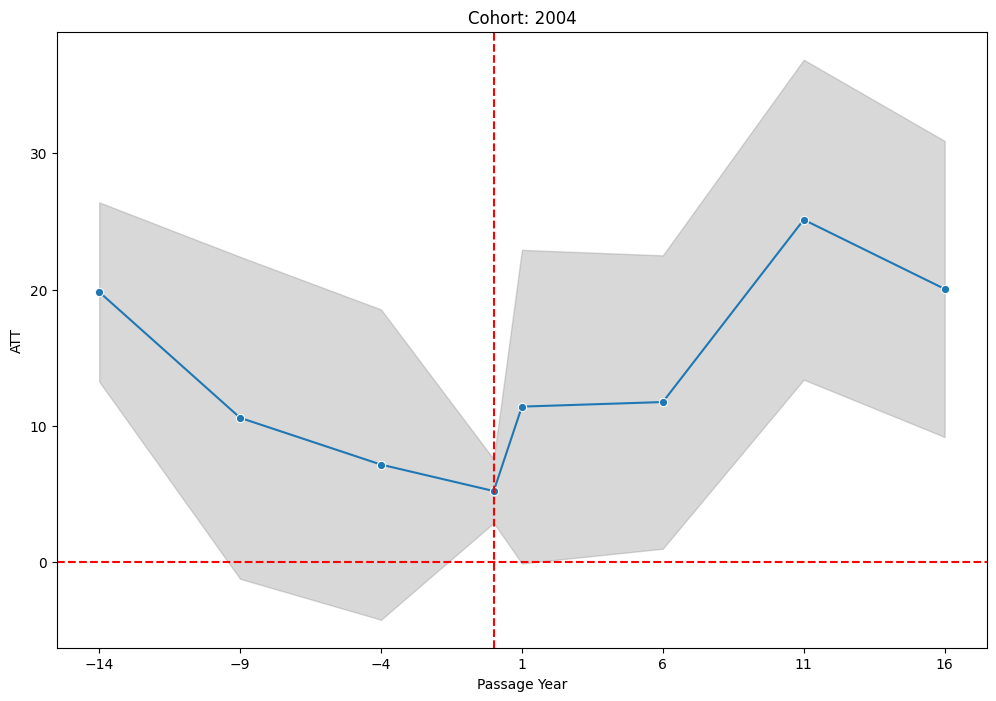

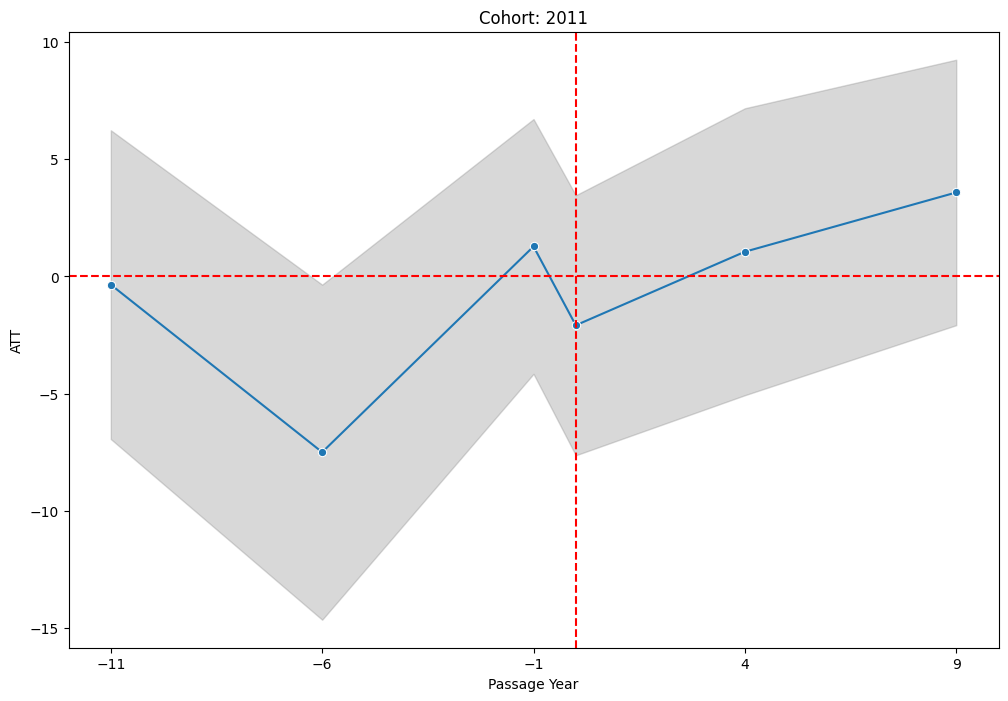

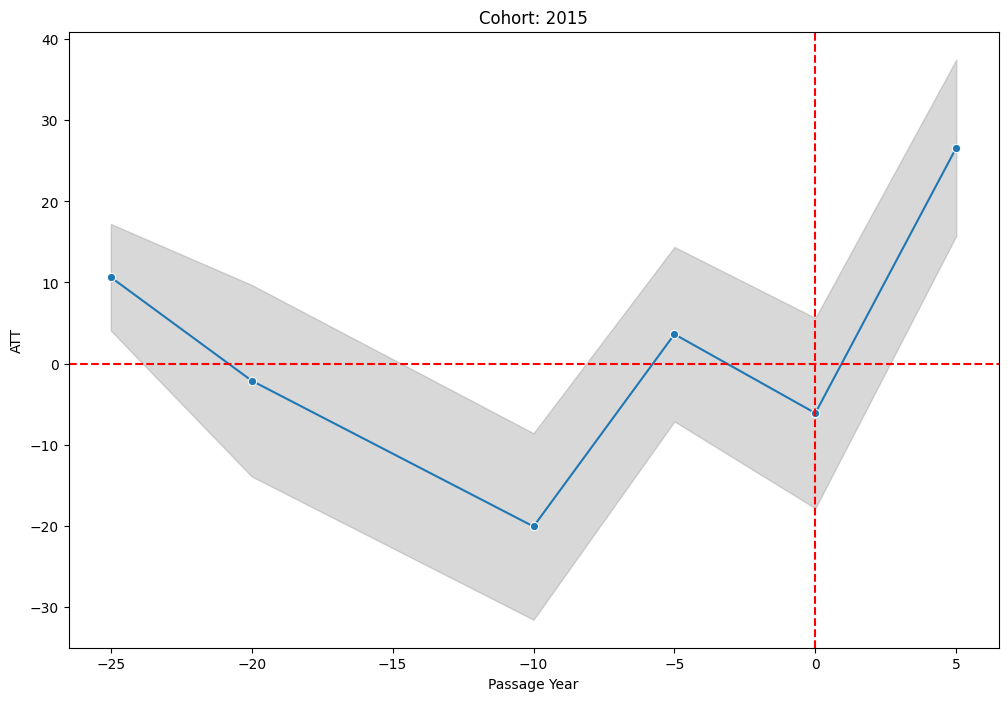

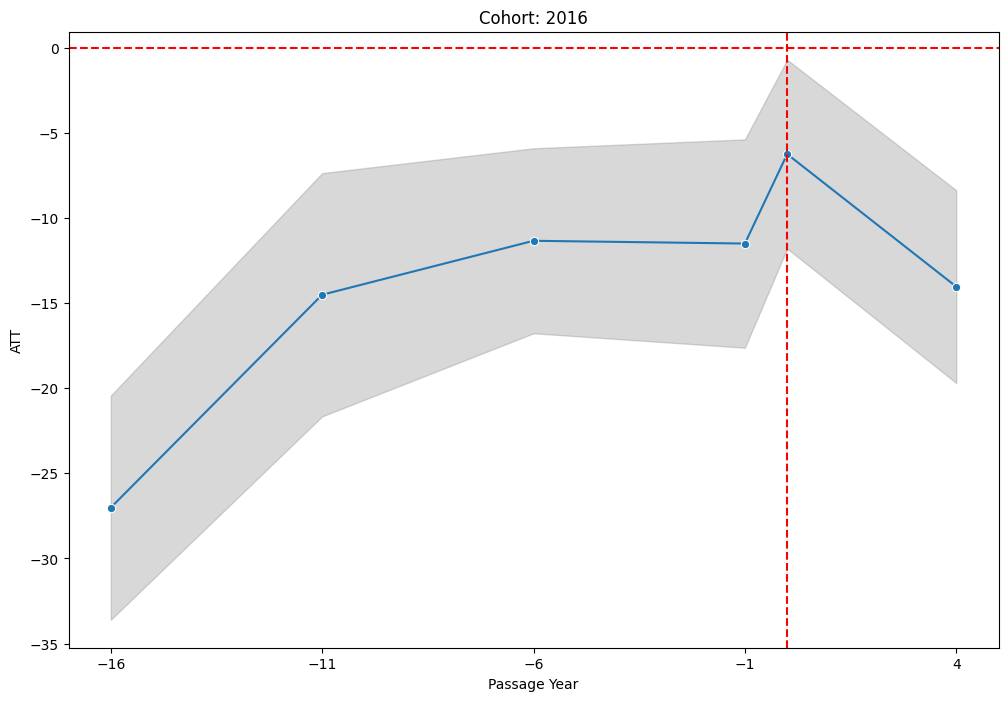

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 各cohortごとに個別のプロットを作成
for cohort in params_years_cohort['cohort'].unique():
    cohort_data = params_years_cohort[params_years_cohort['cohort'] == cohort]
    
    plt.figure(figsize=(12, 8))
    
    # エラーバーを追加
    plt.fill_between(
        cohort_data['passage_year'],
        cohort_data['estimate'] - 1.96 * cohort_data['std_error'],
        cohort_data['estimate'] + 1.96 * cohort_data['std_error'],
        color='gray',
        alpha=0.3
    )
    
    # ラインプロットを追加
    sns.lineplot(data=cohort_data, x='passage_year', y='estimate', marker='o')
    
    # x軸のメモリを1ずつに設定
    x_min = cohort_data['passage_year'].min()
    x_max = cohort_data['passage_year'].max()
    xticks = np.arange(np.floor(x_min), np.ceil(x_max) + 1, 5)
    plt.xticks(xticks)
    
    # y=0の線を追加
    plt.axhline(y=0, color='red', linestyle='--')
    # x=0の線を追加
    plt.axvline(x=0, color='red', linestyle='--')
    
    # ラベルとタイトルの設定
    plt.xlabel('Passage Year')
    plt.ylabel('ATT')
    plt.title(f'Cohort: {cohort}')
    
    # プロットを表示
    plt.show()